In [1]:
from collections import Counter
from importlib import reload
from typing import List

import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from serial import Serial

import spectrum_painting as sp
import spectrum_painting_data as sp_data
import spectrum_painting_model as sp_model
import spectrum_painting_plotting as sp_plot
import spectrum_painting_predict as sp_predict
import spectrum_painting_training as sp_training

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Convert MATLAB data to numpy files to make loading quicker

See `convert_matlab_to_numpy.py` to do call this manually without running it in the notebook.

# Load spectrograms

In [2]:
# Reload spectrum painting module in case the code changed
# and you want what is executed to be what you wrote.
reload(sp_data)
reload(sp)

spectrograms = sp_data.load_spectrograms(data_dir="data/numpy-2",
                                         classes=["Z", "B", "W", "BW", "ZB", "ZW", "ZBW"],
                                         snr_list=[10, 30],
                                         # 20 MHz
                                         sample_rate=20000000,
                                         count=100000000,
                                         window_length=256)

In [10]:
# filtered_spectrograms = {k: list(filter(lambda s: s.snr == 30, v)) for (k, v) in spectrograms.items()}

In [38]:
reload(sp)
reload(sp_plot)
reload(sp_predict)
reload(sp_training)

train_test_sets = sp_training.create_spectrum_painting_train_test_sets(
    spectrograms=spectrograms,
    options=sp_training.SpectrumPaintingTrainingOptions(
        spectrogram_length=5000,
        downsample_resolution=64,
        k=3,
        l=16,
        d=4,
        color_depth=256
    ),
    test_size=0.3
)

print(f"Number of training images: {len(train_test_sets.y_train)}")
print(f"Number of testing images: {len(train_test_sets.y_test)}")

Number of training images: 2018
Number of testing images: 866


[(0, 281), (1, 303), (2, 274), (3, 281), (4, 302), (5, 286), (6, 291)]
[(0, 131), (1, 109), (2, 138), (3, 131), (4, 110), (5, 126), (6, 121)]


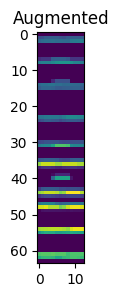

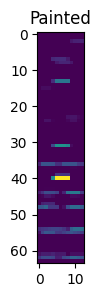

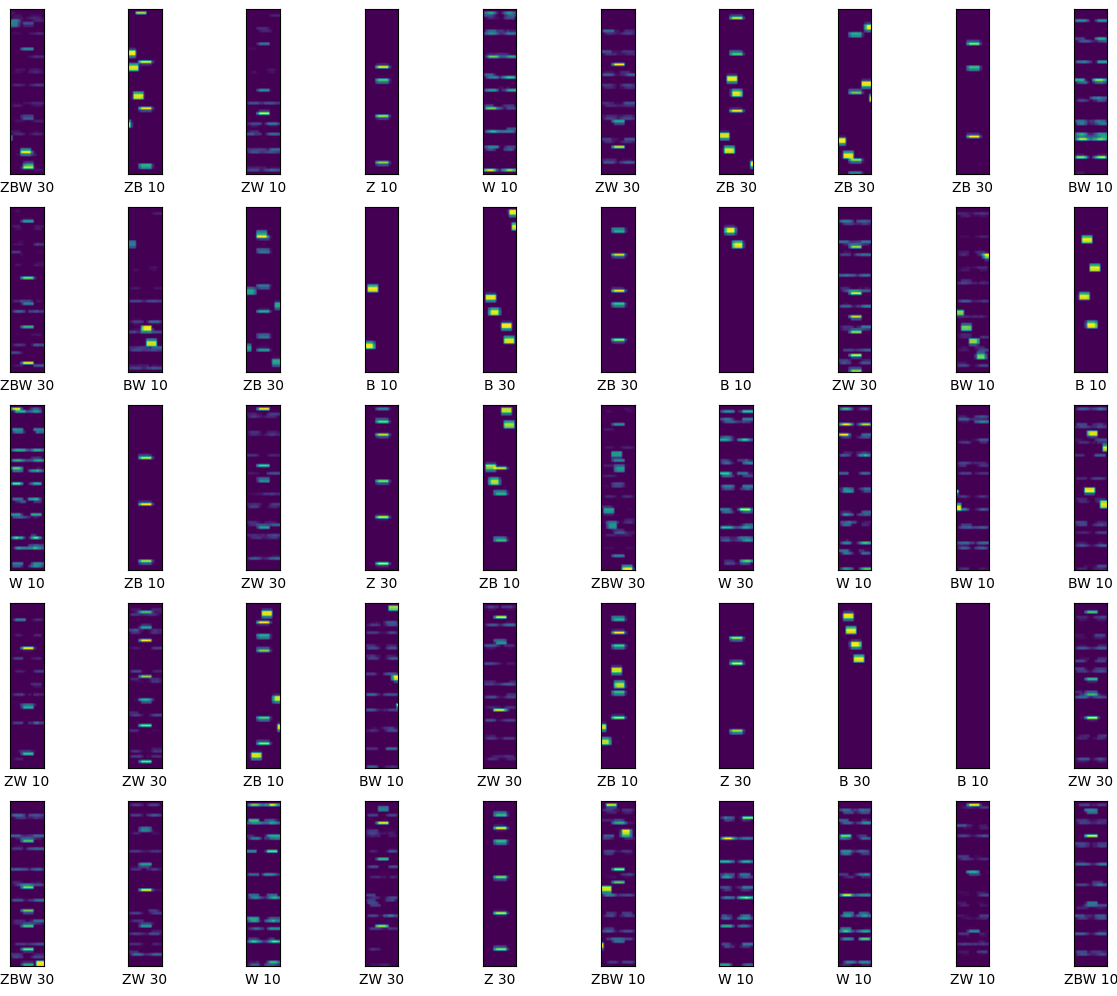

In [39]:
# Show the distribution
print(sorted(Counter(train_test_sets.y_train).items()))
print(sorted(Counter(train_test_sets.y_test).items()))

plt.figure(figsize=(3, 3))
plt.title("Augmented")
plt.imshow(train_test_sets.x_test_augmented[2], cmap='viridis')
plt.show()

painted = train_test_sets.x_test_painted[2]

plt.figure(figsize=(3, 3))
plt.title("Painted")
plt.imshow(train_test_sets.x_test_painted[2], cmap='viridis')
plt.show()

sp_plot.plot_train_images(train_test_sets.x_test_painted,
                          train_test_sets.y_test,
                          train_test_sets.label_names,
                          train_test_sets.test_snr)

# Create TensorFlow model

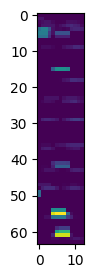

(64, 13)
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 64, 13, 1)]          0         []                            
                                                                                                  
 input_16 (InputLayer)       [(None, 64, 13, 1)]          0         []                            
                                                                                                  
 conv2d_42 (Conv2D)          (None, 64, 13, 8)            400       ['input_15[0][0]']            
                                                                                                  
 conv2d_45 (Conv2D)          (None, 64, 13, 8)            400       ['input_16[0][0]']            
                                                                                   

python(68374) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68375) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


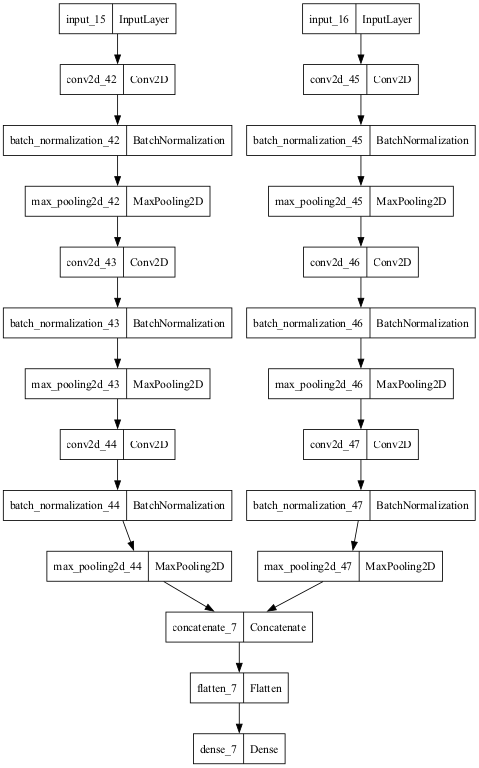

In [40]:
reload(sp_model)

plt.figure(figsize=(3, 3))
plt.imshow(train_test_sets.x_test_painted[0], cmap='viridis')
plt.show()

image_shape = train_test_sets.x_train_augmented[0].shape
print(image_shape)

tf_model = sp_model.create_tensorflow_model(image_shape=image_shape, label_count=len(train_test_sets.label_names))
tf_model.summary()
tf.keras.utils.plot_model(tf_model, to_file="output/model.png", dpi=60)


# Train the TensorFlow model

 Epoch: 97, Val. accuracy = 0.8752886652946472

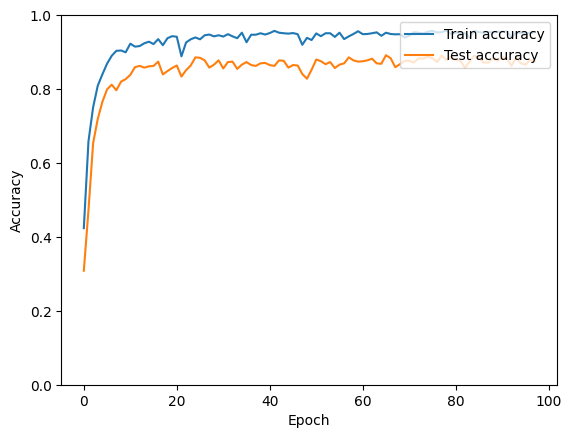

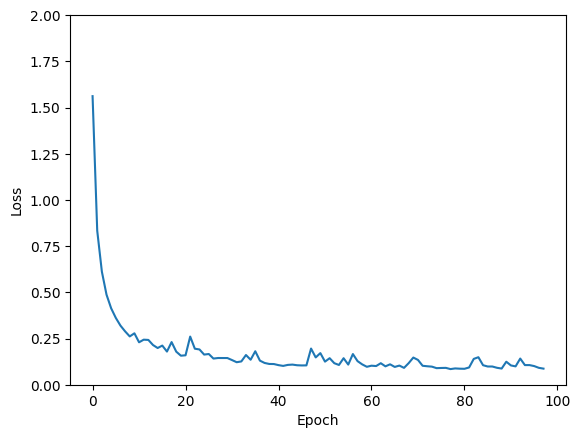

INFO:tensorflow:Assets written to: output/assets


INFO:tensorflow:Assets written to: output/assets


Final loss: 0.447543, final accuracy: 0.875289


In [41]:
reload(sp_model)
history = sp_model.fit_model(tf_model, train_test_sets, epochs=100, early_stopping_patience=20)

sp_plot.plot_model_accuracy_epochs(history)
sp_plot.plot_model_loss(history)

output_file = f"output/spectrum-painting-model-SNR-10.keras"

tf.saved_model.save(tf_model, "output/")
tf_model.save(output_file)

final_loss, final_acc = tf_model.evaluate([train_test_sets.x_test_augmented, train_test_sets.x_test_painted],
                                          train_test_sets.y_test,
                                          verbose=0)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))


# Confusion matrix for TensorFlow model

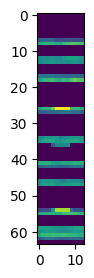

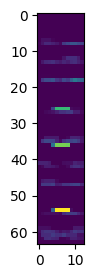

ZW


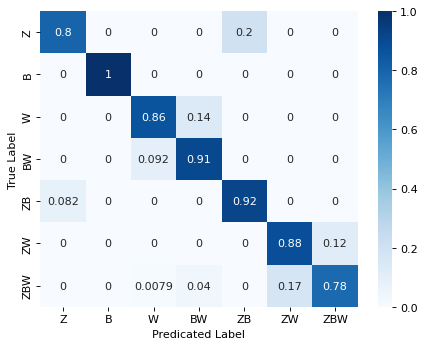

In [37]:
reload(sp_predict)
reload(sp_plot)

# Predict with full Tensorflow
test_img_augmented = train_test_sets.x_test_augmented[17]
test_img_painted = train_test_sets.x_test_painted[17]

plt.figure(figsize=(3, 3))
plt.imshow(test_img_augmented, cmap='viridis')
plt.show()

plt.figure(figsize=(3, 3))
plt.imshow(test_img_painted, cmap='viridis')
plt.show()

prediction = sp_predict.predict_full_model(tf_model, test_img_augmented, test_img_painted)

print(train_test_sets.label_names[prediction])

tf_model_y_predictions = [sp_predict.predict_full_model(tf_model, x_a, x_p) for (x_a, x_p) in
                          zip(train_test_sets.x_test_augmented, train_test_sets.x_test_painted)]

sp_plot.plot_confusion_matrix(tf_model_y_predictions, train_test_sets.y_test, train_test_sets.label_names)

# Convert to Lite model

In [ ]:
reload(sp_model)
tflite_model = sp_model.convert_to_tensorflow_lite(tf_model,
                                                   train_test_sets.x_test_augmented,
                                                   train_test_sets.x_test_painted)
print(f"Done. Model size = {len(tflite_model) // 1000} KB")

lite_output_file = f"output/spectrum-painting-model.tflite"
# Save the model.
with open(lite_output_file, "wb") as f:
    f.write(tflite_model)

# Create a hex dump of the model in a C file for the arduino.
# Use sed to make the variables const since they are huge.
! xxd -i $lite_output_file | sed -e "s/unsigned/const unsigned/"  > ../arduino/spectrum_painting/model.h

In [ ]:
reload(sp_predict)
image_index = 9

# Test with Tensorflow Lite
test_img_augmented = train_test_sets.x_test_augmented[image_index]
test_img_painted = train_test_sets.x_test_painted[image_index]

plt.imshow(test_img_augmented, cmap="viridis")
plt.show()
print(train_test_sets.label_names[train_test_sets.y_test[image_index]])

prediction = sp_predict.predict_lite_model(tflite_model, test_img_augmented, test_img_painted)
print(f"Prediction: {train_test_sets.label_names[prediction]}")

# Confusion matrix for Lite model

In [ ]:
tflite_model_y_predictions: List[int] = []

for x_aug, x_painted in list(zip(train_test_sets.x_test_augmented, train_test_sets.x_test_painted)):
    tflite_model_y_predictions.append(sp_predict.predict_lite_model(tflite_model, x_aug, x_painted))

tflite_accuracy = np.sum(train_test_sets.y_test == tflite_model_y_predictions) / len(train_test_sets.y_test)

print(f"Lite model accuracy = {tflite_accuracy}")
sp_plot.plot_confusion_matrix(np.asarray(tflite_model_y_predictions),
                              train_test_sets.y_test,
                              train_test_sets.label_names)

# Test Lite model and save test images for Arduino

In [ ]:
image_index = 0

test_img_augmented = train_test_sets.x_test_augmented[image_index]
test_img_painted = train_test_sets.x_test_painted[image_index]

print(test_img_augmented.shape)
print(f"Label index {train_test_sets.y_test[image_index]}")
print(f"Label {train_test_sets.label_names[train_test_sets.y_test[image_index]]}")

plt.imshow(test_img_augmented, cmap='viridis')
plt.show()

test_img_augmented.shape += (1,)
test_img_augmented = (np.expand_dims(test_img_augmented, 0))
test_img_augmented = test_img_augmented.astype(np.uint8)

test_img_painted.shape += (1,)
test_img_painted = (np.expand_dims(test_img_painted, 0))
test_img_painted = test_img_painted.astype(np.uint8)

with open('output/augmented_image.bytes', 'wb') as f:
    f.write(test_img_augmented.flatten())

with open('output/painted_image.bytes', 'wb') as f:
    f.write(test_img_painted.flatten())

# Create a hex dump of the image in a C file for the arduino.
! xxd -i output/augmented_image.bytes | sed -e "s/unsigned/const unsigned/"  > ../arduino/spectrum_painting/painted_image.h
! xxd -i output/painted_image.bytes | sed -e "s/unsigned/const unsigned/"  > ../arduino/spectrum_painting/augmented_image.h

# Compile and upload to arduino

In [ ]:
! arduino-cli compile --fqbn arduino:mbed:nano33ble ../arduino/spectrum_painting/spectrum_painting.ino
! arduino-cli upload --fqbn arduino:mbed:nano33ble ../arduino/spectrum_painting/spectrum_painting.ino --port /dev/cu.usbmodem2101

serial = Serial(port="/dev/cu.usbmodem2101", baudrate=9600, timeout=1000)

prediction = int(serial.readline().strip())
time = int(serial.readline().strip())
print(f"Full accuracy = {final_acc}")
print(f"Lite model size = {len(tflite_model) / 1000} KB, Lite accuracy = {tflite_accuracy}")
print(f"Prediction = {train_test_sets.label_names[prediction]}, Time = {time}ms")